In [ ]:
!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

     |████████████████████████████████| 727kB 5.2MB/s 
     |████████████████████████████████| 51kB 5.6MB/s 
     |████████████████████████████████| 1.2MB 8.5MB/s 
     |████████████████████████████████| 194kB 25.6MB/s 
     |████████████████████████████████| 61kB 7.5MB/s 
Mounted at /content/gdrive


In [ ]:
from fastbook import *
from pandas.api.types import is_string_dtype, is_numeric_dtype, is_categorical_dtype
from fastai.tabular.all import *
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from IPython.display import Image, display_svg, SVG
import matplotlib.pyplot as plt

pd.options.display.max_rows = 20
pd.options.display.max_columns = 8

# Data

In [ ]:
A = pd.read_csv('data/Dataset1_full.csv')
B = pd.read_csv('data/Dataset2_full.csv')
C = pd.read_csv('data/Dataset3_full.csv')

In [ ]:
A = A.drop(columns=['year', 'month', 'day', 'hour', 'minute', 'WSF_int', 'windSpeed'])
B = B.drop(columns=['year', 'month', 'day', 'hour', 'minute', 'WSF_int', 'windSpeed'])
C = C.drop(columns=['year', 'month', 'day', 'hour', 'minute', 'WSF_int'])

In [ ]:
#B['availableMW'] = np.where(B['availableMW'].isna(), 99, B['availableMW'])
#A['availableMW'] = np.where(A['availableMW'].isna(), 44, A['availableMW'])
C['availableMW'] = 99

In [ ]:
A['farm'] = 'A'
B['farm'] = 'B'
C['farm'] = 'B'

In [ ]:
df =pd.concat([A, B])

In [ ]:
df = df[df['windPower']!=7.04444]

In [ ]:
df = df.dropna(subset=['windPower'])

In [ ]:
# Interpolation
df = df.fillna(method='ffill')
#df = pd.concat([df,pd.get_dummies(df['farm'], prefix='farm')],axis=1)
#df = df.drop(columns=['farm'])
df['timeStamp'] = pd.to_datetime(df['timeStamp'])

In [ ]:
df = df.reset_index(drop=True)

In [ ]:
df.columns

Index(['timeStamp', 'availableMW', 'windPower', 'windDic (degree)',
       'windSpeed_5min', 'farm'],
      dtype='object')

# windPower model

In [ ]:
train = df.copy()
train = train[['timeStamp', 'windSpeed_5min', 'windPower', 'farm', 'availableMW', 'windDic (degree)']]

In [ ]:
train.columns

Index(['timeStamp', 'windSpeed_5min', 'windPower', 'farm', 'availableMW',
       'windDic (degree)'],
      dtype='object')

# Features

In [ ]:
#train['windPower'] = np.where(train['windPower']<1,1, train['windPower'])
train['y'] = (train['windPower'])
train = train.drop(columns=['windPower'])

In [ ]:
train['windspeed_cat'] = pd.cut(train['windSpeed_5min'], bins=[0,5.28, 7.78, 8.61, 10.56, 100],
                                labels=['low', 'medium', 'medium_h', 'high', 'veryhigh'])

In [ ]:
train.loc[train['farm']=='A', 'windspeed'] = train['windSpeed_5min']*(45)
train.loc[train['farm']=='B', 'windspeed'] = train['windSpeed_5min']*(99)
#train = train.drop(columns=['farm'])
train = train.drop(columns=['windSpeed_5min'])

In [ ]:
train['speed_rolling_lag1'] = train['windspeed'].rolling(48).mean()
train['speed_rolling_lag2'] = train['windspeed'].rolling(24).mean()
train['speed_rolling_n1'] = train['windspeed'].shift(-48).rolling(48).mean()
train['speed_rolling_n2'] = train['windspeed'].shift(-24).rolling(24).mean()

In [ ]:
train['change_lag'] = (train['windspeed']/train['speed_rolling_lag2'])-1
train['change_n'] = (train['speed_rolling_n2']/train['windspeed'])-1

In [ ]:
train.loc[(train['windDic (degree)']>=0)&(train['windDic (degree)']<22.5), 'windDic_cat'] = 'N'
train.loc[(train['windDic (degree)']>=337.5)&(train['windDic (degree)']<=360), 'windDic_cat'] = 'N'
train.loc[(train['windDic (degree)']>=22.5)&(train['windDic (degree)']<67.5), 'windDic_cat'] = 'NE'
train.loc[(train['windDic (degree)']>=67.5)&(train['windDic (degree)']<112.5), 'windDic_cat'] = 'E'
train.loc[(train['windDic (degree)']>=112.5)&(train['windDic (degree)']<157.5), 'windDic_cat'] = 'SE'
train.loc[(train['windDic (degree)']>=157.5)&(train['windDic (degree)']<202.5), 'windDic_cat'] = 'S'
train.loc[(train['windDic (degree)']>=202.5)&(train['windDic (degree)']<247.5), 'windDic_cat'] = 'SW'
train.loc[(train['windDic (degree)']>=247.5)&(train['windDic (degree)']<292.5), 'windDic_cat'] = 'W'
train.loc[(train['windDic (degree)']>=292.5)&(train['windDic (degree)']<337.5), 'windDic_cat'] = 'NW'

In [ ]:
train = train.drop(columns=['windDic (degree)'])

In [ ]:
train.loc[(train['timeStamp'].dt.month>=3)&(train['timeStamp'].dt.month<=5), 'season'] = 'Spring'
train.loc[(train['timeStamp'].dt.month>=6)&(train['timeStamp'].dt.month<=8), 'season'] = 'Summer'
train.loc[(train['timeStamp'].dt.month>=9)&(train['timeStamp'].dt.month<=11), 'season'] = 'Autumn'
train.loc[(train['timeStamp'].dt.month>=12)|(train['timeStamp'].dt.month<=2), 'season'] = 'Winter'

In [ ]:
train['Months'] = train.timeStamp.dt.strftime('%b')
#train['Months'] = train['Months'].cat.set_categories(months)

In [ ]:
train.columns

Index(['timeStamp', 'farm', 'availableMW', 'y', 'windspeed_cat', 'windspeed',
       'speed_rolling_lag1', 'speed_rolling_lag2', 'speed_rolling_n1',
       'speed_rolling_n2', 'change_lag', 'change_n', 'windDic_cat', 'season',
       'Months'],
      dtype='object')

In [ ]:
train = train.dropna()

In [ ]:
#train = add_datepart(train, 'timeStamp')

In [ ]:
train.columns

Index(['timeStamp', 'farm', 'availableMW', 'y', 'windspeed_cat', 'windspeed',
       'speed_rolling_lag1', 'speed_rolling_lag2', 'speed_rolling_n1',
       'speed_rolling_n2', 'change_lag', 'change_n', 'windDic_cat', 'season',
       'Months'],
      dtype='object')

# Variables

# Train/Test

In [ ]:
cond = (train.timeStamp.dt.week<50)
train_idx = np.where( cond)[0]
valid_idx = np.where(~cond)[0]

splits = (list(train_idx),list(valid_idx))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  """Entry point for launching an IPython kernel.


In [ ]:
original = train.copy()

In [ ]:
train = train.drop(columns=['timeStamp'])

In [ ]:
train['windspeed_cat'] = train['windspeed_cat'].astype('str')

In [ ]:
cont,cat = cont_cat_split(train, 1, dep_var='y')

In [ ]:
procs = [Categorify, FillMissing]

In [ ]:
to = TabularPandas(train, procs, cat, cont, y_names='y', splits=splits)

In [ ]:
dls = to.dataloaders(512)

In [ ]:
simple_net = nn.Sequential(
    nn.Linear(28*28,30),
    nn.ReLU(),
    nn.Linear(30,1)
)

In [ ]:
learn = tabular_learner(dls, layers=[400, 200],
                        n_out=1, loss_func=F.mse_loss)

SuggestedLRs(lr_min=0.025118863582611083, lr_steep=0.00363078061491251)

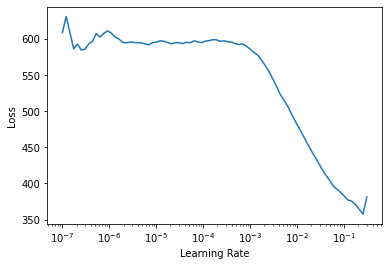

In [ ]:
learn.lr_find()

In [ ]:
learn.fit(15, 1e-3)

In [ ]:
def r_mse(pred,y): return round(math.sqrt(((pred-y)**2).mean()), 6)
def m_rmse(m, xs, y): return r_mse(m.predict(xs), y)

In [ ]:
preds,targs = learn.get_preds()
r_mse(preds,targs)

11.563923

In [ ]:
temp = pd.DataFrame(targs, columns=['y'])
temp['preds'] = preds.numpy()
temp['dif'] = temp['y']-temp['preds']

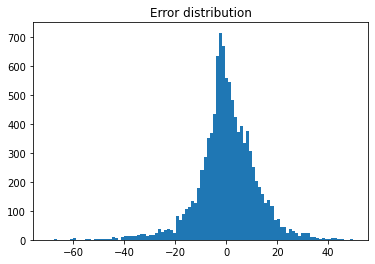

In [ ]:
plt.hist(temp['dif'], bins=100)
plt.title('Error distribution')
plt.show()

In [ ]:
res = original.iloc[valid_idx].copy()
res['preds'] = preds.numpy()

In [ ]:
pd.options.display.max_columns = 999

In [ ]:
res

timeStamp farm  availableMW    y windspeed_cat    windspeed  \
86466  2019-01-01 00:00:00    B         99.0  0.0          high   959.193661   
86467  2019-01-01 00:05:00    B         99.0  0.0          high   959.249992   
86468  2019-01-01 00:10:00    B         99.0  0.0          high   959.306324   
86469  2019-01-01 00:15:00    B         99.0  0.0          high   959.362655   
86470  2019-01-01 00:20:00    B         99.0  0.0          high   959.418986   
...                    ...  ...          ...  ...           ...          ...   
112982 2019-12-01 20:00:00    B         99.0  0.0          high   972.084403   
112983 2019-12-01 21:00:00    B         99.0  0.0          high  1001.454613   
112984 2019-12-01 22:00:00    B         99.0  0.0          high  1043.499087   
112985 2019-12-01 23:00:00    B         99.0  0.0      veryhigh  1064.676348   
112986 2019-12-02 00:00:00    B         99.0  0.0      veryhigh  1053.041926   

        speed_rolling_lag1  speed_rolling_lag2  speed_rolling_n1  \
86466           488.351535          476.787439        662.800818   
86467           497.392973          497.148479        659.836597   
86468           506.477257          517.581295        656.917652   
86469           515.604389          538.085885        654.043982   
86470           524.774369          558.662250        651.215587   
...                    ...                 ...               ...   
112982         1146.042577          979.903149        841.910960   
112983         1146.470864          991.622548        849.505217   
112984         1147.266638         1009.513385        855.422939   
112985         1148.073786         1032.641701        859.800447   
112986         1141.010980         1031.782352        846.543403   

        speed_rolling_n2  change_lag  change_n windDic_cat  season Months  \
86466         696.353937    1.011785 -0.274022          NW  Winter    Jan   
86467         677.018666    0.929504 -0.294221          NW  Winter    Jan   
86468         658.057066    0.853441 -0.314028          NW  Winter    Jan   
86469         639.469140    0.782917 -0.333444          NW  Winter    Jan   
86470         621.254886    0.717351 -0.352468          NW  Winter    Jan   
...                  ...         ...       ...         ...     ...    ...   
112982        847.512013   -0.007979 -0.128150           W  Winter    Dec   
112983        823.735182    0.009915 -0.177461           W  Winter    Dec   
112984        797.150959    0.033665 -0.236079           W  Winter    Dec   
112985        768.763632    0.031022 -0.277937           W  Winter    Dec   
112986        741.053315    0.020605 -0.296274           N  Winter    Dec   

            preds  
86466   35.324844  
86467   35.593716  
86468   36.226284  
86469   36.178112  
86470   36.656631  
...           ...  
112982  63.403107  
112983  65.195938  
112984  66.988739  
112985  68.146889  
112986  60.153099  

[26521 rows x 16 columns]

In [ ]:
res.to_csv('res.csv', index=False)

In [ ]:
learn.export('hackathon.pkl')

# Predictions

In [ ]:
C['availableMW'] = 99
C['farm'] = 'B'

In [ ]:
eval = C.copy()

In [ ]:
eval['farm'] = 'B'
eval['availableMW'] = 99
eval = eval.fillna(method='bfill')

In [ ]:
eval.columns

Index(['timeStamp', 'windDic (degree)', 'windSpeed_5min', 'availableMW',
       'farm'],
      dtype='object')

In [ ]:
eval['windspeed_cat'] = pd.cut(eval['windSpeed_5min'], bins=[0,5.28, 7.78, 8.61, 10.56, 100],
                                labels=['low', 'medium', 'medium_h', 'high', 'veryhigh'])

In [ ]:
eval.loc[eval['farm']=='B', 'windspeed'] = eval['windSpeed_5min']*(99)
#train = train.drop(columns=['farm'])
eval = eval.drop(columns=['windSpeed_5min'])

In [ ]:
eval['speed_rolling_lag1'] = eval['windspeed'].rolling(48).mean()
eval['speed_rolling_lag2'] = eval['windspeed'].rolling(24).mean()
eval['speed_rolling_n1'] = eval['windspeed'].shift(-48).rolling(48).mean()
eval['speed_rolling_n2'] = eval['windspeed'].shift(-24).rolling(24).mean()

In [ ]:
eval['change_lag'] = (eval['windspeed']/eval['speed_rolling_lag2'])-1
eval['change_n'] = (eval['speed_rolling_n2']/eval['windspeed'])-1

In [ ]:
eval.loc[(eval['windDic (degree)']>=0)&(eval['windDic (degree)']<22.5), 'windDic_cat'] = 'N'
eval.loc[(eval['windDic (degree)']>=337.5)&(eval['windDic (degree)']<=360), 'windDic_cat'] = 'N'
eval.loc[(eval['windDic (degree)']>=22.5)&(eval['windDic (degree)']<67.5), 'windDic_cat'] = 'NE'
eval.loc[(eval['windDic (degree)']>=67.5)&(eval['windDic (degree)']<112.5), 'windDic_cat'] = 'E'
eval.loc[(eval['windDic (degree)']>=112.5)&(eval['windDic (degree)']<157.5), 'windDic_cat'] = 'SE'
eval.loc[(eval['windDic (degree)']>=157.5)&(eval['windDic (degree)']<202.5), 'windDic_cat'] = 'S'
eval.loc[(eval['windDic (degree)']>=202.5)&(eval['windDic (degree)']<247.5), 'windDic_cat'] = 'SW'
eval.loc[(eval['windDic (degree)']>=247.5)&(eval['windDic (degree)']<292.5), 'windDic_cat'] = 'W'
eval.loc[(eval['windDic (degree)']>=292.5)&(eval['windDic (degree)']<337.5), 'windDic_cat'] = 'NW'

In [ ]:
eval = eval.drop(columns=['windDic (degree)'])

In [ ]:
eval['timeStamp'] = pd.to_datetime(eval['timeStamp'] )

In [ ]:
eval.loc[(eval['timeStamp'].dt.month>=3)&(eval['timeStamp'].dt.month<=5), 'season'] = 'Spring'
eval.loc[(eval['timeStamp'].dt.month>=6)&(eval['timeStamp'].dt.month<=8), 'season'] = 'Summer'
eval.loc[(eval['timeStamp'].dt.month>=9)&(eval['timeStamp'].dt.month<=11), 'season'] = 'Autumn'
eval.loc[(eval['timeStamp'].dt.month>=12)|(eval['timeStamp'].dt.month<=2), 'season'] = 'Winter'

In [ ]:
eval['Months'] = eval.timeStamp.dt.strftime('%b')

In [ ]:
var = ['farm', 'availableMW', 'windspeed_cat', 'windspeed',
       'speed_rolling_lag1', 'speed_rolling_lag2', 'speed_rolling_n1',
       'speed_rolling_n2', 'change_lag', 'change_n', 'windDic_cat', 'season',
       'Months']

In [ ]:
eval = eval.fillna(method='bfill')

In [ ]:
eval = eval.fillna(method='ffill')

In [ ]:
row, clas, probs = learn.predict(eval.iloc[0])

In [ ]:
len(eval)

26569

In [ ]:
preds = []
for i in range(0, len(eval)):

  row, clas, probs = learn.predict(eval.iloc[i])
  preds.append(clas.numpy()[0])


In [ ]:
len(preds)

26569

In [ ]:
C['prediction'] = preds

In [ ]:
C.head()

timeStamp  windDic (degree)  windSpeed_5min  availableMW farm  \
0  2019-01-01 00:00:00               NaN        9.688825           99    B   
1  2019-01-01 00:05:00               NaN        9.689394           99    B   
2  2019-01-01 00:10:00               NaN        9.689963           99    B   
3  2019-01-01 00:15:00               NaN        9.690532           99    B   
4  2019-01-01 00:20:00               NaN        9.691101           99    B   

   prediction  
0   36.306580  
1   36.308491  
2   36.310402  
3   36.312313  
4   36.314224

In [ ]:
B = B.drop(columns=['availableMW', 'windPower', 'windDic (degree)', 'windSpeed_5min'])

In [ ]:
C.to_csv('results.csv', index=False)